In [ ]:
# Import Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score,accuracy_score
import os
import cv2
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")


Libraries imported successfully!
TensorFlow version: 2.15.0


In [ ]:
#  Load Dataset
# Define paths to dataset directories
train_dir = 'chest_xray/train'
val_dir = 'chest_xray/val'
test_dir = 'chest_xray/test'

# Check subdirectories in each
if os.path.exists(train_dir):
    print(f"Train subdirectories: {os.listdir(train_dir)}")
if os.path.exists(val_dir):
    print(f"Validation subdirectories: {os.listdir(val_dir)}")
if os.path.exists(test_dir):
    print(f"Test subdirectories: {os.listdir(test_dir)}")

# Count images in each class
def count_images_in_directory(directory):
    normal_count = len(os.listdir(os.path.join(directory, 'NORMAL')))
    pneumonia_count = len(os.listdir(os.path.join(directory, 'PNEUMONIA')))
    total = normal_count + pneumonia_count
    return normal_count, pneumonia_count, total

train_normal, train_pneumonia, train_total = count_images_in_directory(train_dir)
val_normal, val_pneumonia, val_total = count_images_in_directory(val_dir)
test_normal, test_pneumonia, test_total = count_images_in_directory(test_dir)


print(f"TRAIN SET: NORMAL: {train_normal} ({train_normal/train_total*100:.1f}%), PNEUMONIA: {train_pneumonia} ({train_pneumonia/train_total*100:.1f}%)")
print(f"VALIDATION SET: NORMAL: {val_normal} ({val_normal/val_total*100:.1f}%), PNEUMONIA: {val_pneumonia} ({val_pneumonia/val_total*100:.1f}%)")
print(f"TEST SET: NORMAL: {test_normal} ({test_normal/test_total*100:.1f}%), PNEUMONIA: {test_pneumonia} ({test_pneumonia/test_total*100:.1f}%)")

Train subdirectories: ['NORMAL', 'PNEUMONIA']
Validation subdirectories: ['NORMAL', 'PNEUMONIA']
Test subdirectories: ['NORMAL', 'PNEUMONIA']
TRAIN SET: NORMAL: 1341 (25.7%), PNEUMONIA: 3875 (74.3%)
VALIDATION SET: NORMAL: 8 (50.0%), PNEUMONIA: 8 (50.0%)
TEST SET: NORMAL: 234 (37.5%), PNEUMONIA: 390 (62.5%)


Sample NORMAL images from training set:


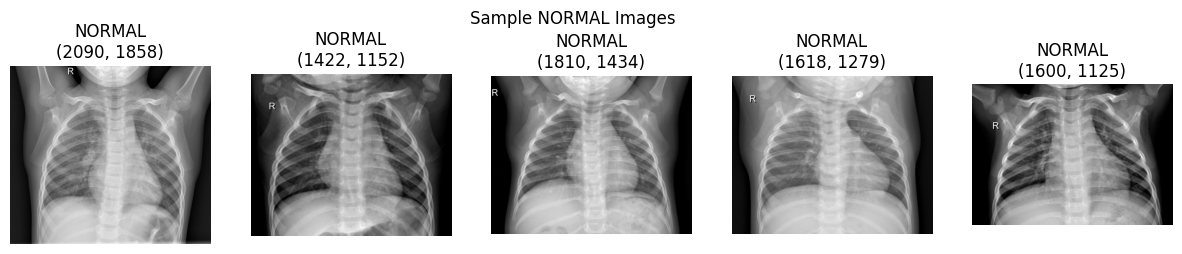

Sample PNEUMONIA images from training set:


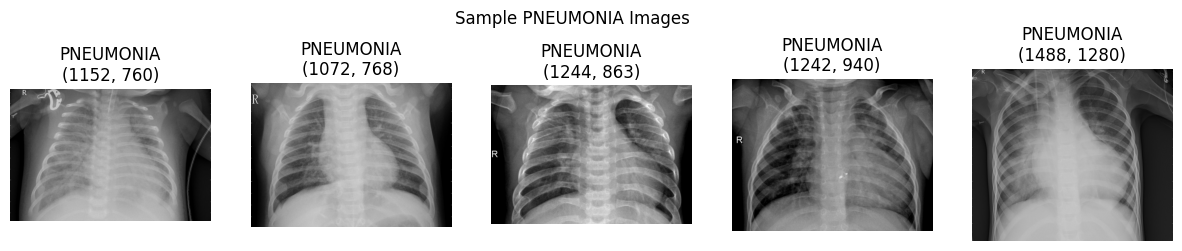

In [ ]:
#Explore the Data (EDA)
# Display sample images and basic statistics
def display_sample_images(directory, class_name, num_samples=5):
    class_path = os.path.join(directory, class_name)
    images = os.listdir(class_path)[:num_samples]
    
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i, img_name in enumerate(images):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'{class_name}\n{img.size}')
        axes[i].axis('off')
    plt.suptitle(f'Sample {class_name} Images')
    plt.show()

# Display samples from both classes in training set
print("Sample NORMAL images from training set:")
display_sample_images(train_dir, 'NORMAL')

print("Sample PNEUMONIA images from training set:")
display_sample_images(train_dir, 'PNEUMONIA')

# Get image dimensions statistics
def get_image_dimensions(directory):
    dimensions = []
    for class_name in ['NORMAL', 'PNEUMONIA']:
        class_path = os.path.join(directory, class_name)
        for img_name in os.listdir(class_path)[:50]:  # Sample 50 images per class
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)
            dimensions.append(img.size)
    return dimensions



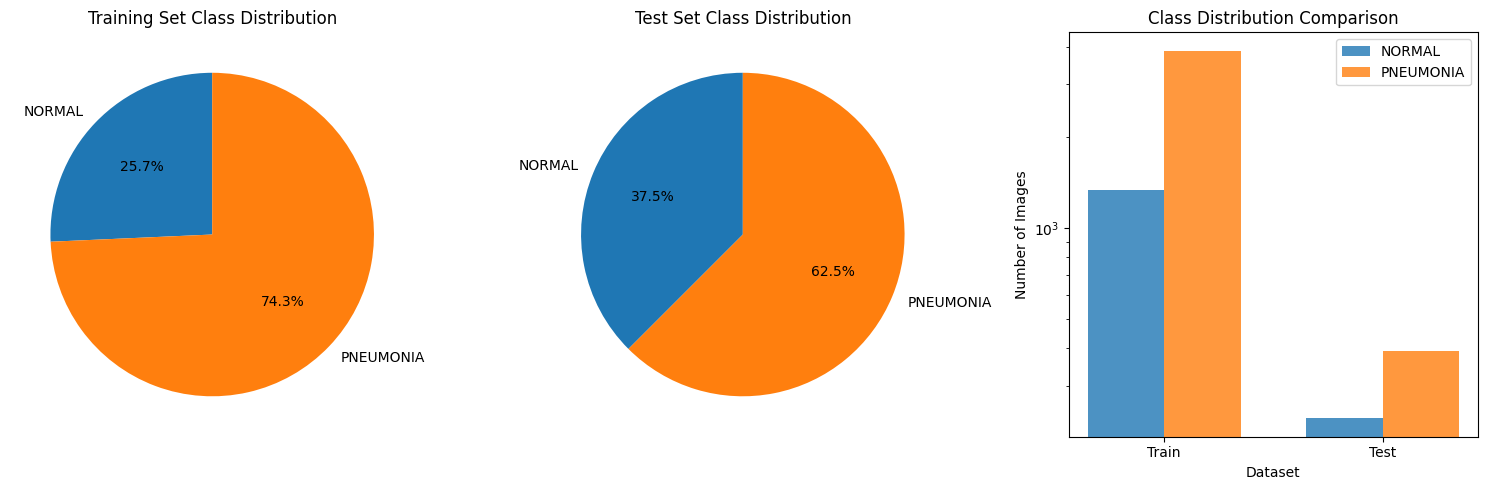

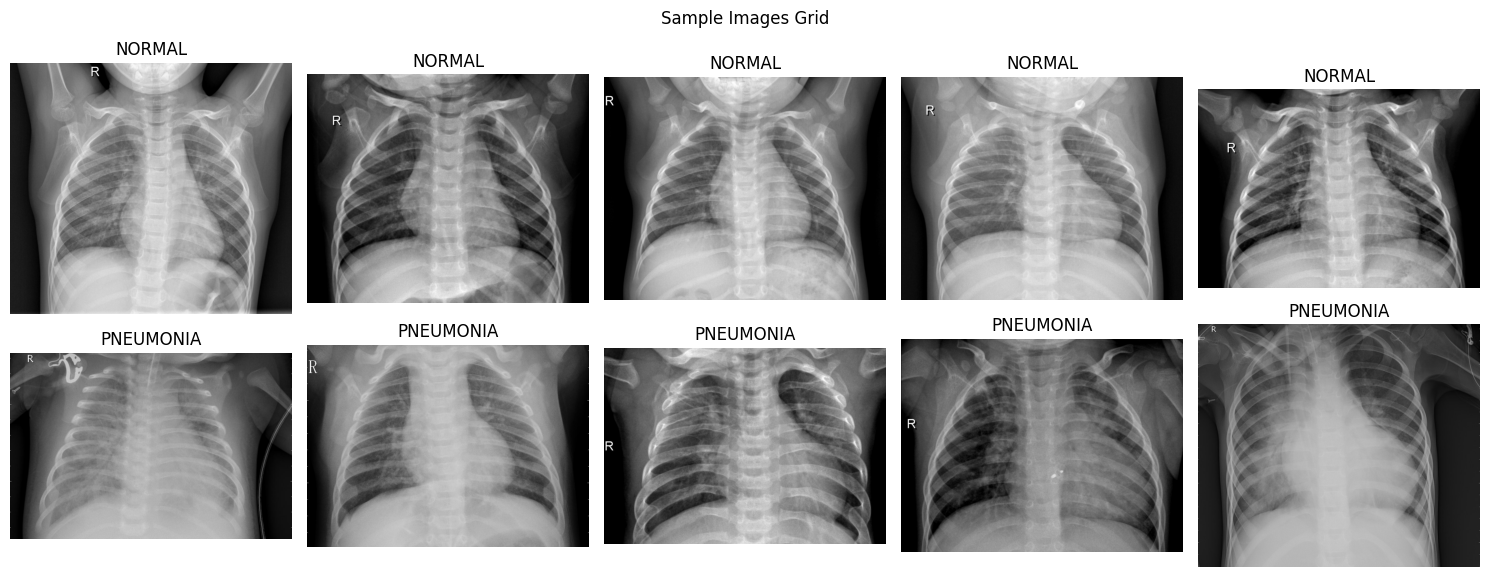

In [ ]:
# Visualize the Data
# Plot class distribution and visualize samples
plt.figure(figsize=(15, 5))

# Plot 1: Class distribution in training set
plt.subplot(1, 3, 1)
train_labels = ['NORMAL', 'PNEUMONIA']
train_counts = [train_normal, train_pneumonia]
plt.pie(train_counts, labels=train_labels, autopct='%1.1f%%', startangle=90)
plt.title('Training Set Class Distribution')

# Plot 2: Class distribution in test set
plt.subplot(1, 3, 2)
test_labels = ['NORMAL', 'PNEUMONIA']
test_counts = [test_normal, test_pneumonia]
plt.pie(test_counts, labels=test_labels, autopct='%1.1f%%', startangle=90)
plt.title('Test Set Class Distribution')

# Plot 3: Bar chart comparison
plt.subplot(1, 3, 3)
x = np.arange(2)
width = 0.35
plt.bar(x - width/2, [train_normal, test_normal], width, label='NORMAL', alpha=0.8)
plt.bar(x + width/2, [train_pneumonia, test_pneumonia], width, label='PNEUMONIA', alpha=0.8)
plt.xlabel('Dataset')
plt.ylabel('Number of Images')
plt.title('Class Distribution Comparison')
plt.xticks(x, ['Train', 'Test'])
plt.legend()
plt.yscale('log')  # Log scale to better visualize differences

plt.tight_layout()
plt.show()

# Additional visualization: Sample images grid
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, class_name in enumerate(['NORMAL', 'PNEUMONIA']):
    class_path = os.path.join(train_dir, class_name)
    images = os.listdir(class_path)[:5]
    for j, img_name in enumerate(images):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)
        # Convert grayscale to RGB for consistent display
        if img.mode != 'RGB':
            img = img.convert('RGB')
        axes[i, j].imshow(img)
        axes[i, j].set_title(f'{class_name}')
        axes[i, j].axis('off')
plt.suptitle('Sample Images Grid')
plt.tight_layout()
plt.show()

In [ ]:
#Preprocess the Data
import math

IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32

# More  augmentation for medical images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,        
    width_shift_range=0.1,    
    height_shift_range=0.1,   
    horizontal_flip=True,     
    zoom_range=0.1,           
    fill_mode='nearest'
)

# Only rescaling for validation and test sets
val_test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

# Use batch_size=8 for validation 
validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=8,  
    class_mode='binary',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


print(f"Training samples: {train_generator.samples}, Batch size: {train_generator.batch_size}")
print(f"Validation samples: {validation_generator.samples}, Batch size: {validation_generator.batch_size}")
print(f"Test samples: {test_generator.samples}, Batch size: {test_generator.batch_size}")

steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = math.ceil(validation_generator.samples / validation_generator.batch_size)
test_steps = math.ceil(test_generator.samples / test_generator.batch_size)

print(f"\nSteps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")
print(f"Test steps: {test_steps}")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Training samples: 5216, Batch size: 32
Validation samples: 16, Batch size: 8
Test samples: 624, Batch size: 32

Steps per epoch: 163
Validation steps: 2
Test steps: 20


In [ ]:

# corrupted or missing images
def check_for_corrupted_images(directory):
    corrupted_files = []
    for class_name in ['NORMAL', 'PNEUMONIA']:
        class_path = os.path.join(directory, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                img = Image.open(img_path)
                img.verify()  # Verify image integrity
            except Exception as e:
                print(f"Corrupted image found: {img_path} - {e}")
                corrupted_files.append(img_path)
    return corrupted_files

# Check each dataset split
print("Checking for corrupted images...")
corrupted_train = check_for_corrupted_images(train_dir)
corrupted_val = check_for_corrupted_images(val_dir)
corrupted_test = check_for_corrupted_images(test_dir)

print(f"Corrupted images in train set: {len(corrupted_train)}")
print(f"Corrupted images in validation set: {len(corrupted_val)}")
print(f"Corrupted images in test set: {len(corrupted_test)}")

# If there are corrupted images, they should be removed
if corrupted_train or corrupted_val or corrupted_test:
    print("Please remove corrupted images before proceeding!")
else:
    print("No corrupted images found - all images are valid.")

Checking for corrupted images...
Corrupted images in train set: 0
Corrupted images in validation set: 0
Corrupted images in test set: 0
No corrupted images found - all images are valid.


In [ ]:
#Encode Categorical Variables

print(f"Train generator class indices: {train_generator.class_indices}")
print(f"Validation generator class indices: {validation_generator.class_indices}")
print(f"Test generator class indices: {test_generator.class_indices}")

# Store class labels for later use
class_labels = list(train_generator.class_indices.keys())
print(f"Class labels: {class_labels}")

Train generator class indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Validation generator class indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Test generator class indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Class labels: ['NORMAL', 'PNEUMONIA']


In [ ]:
# Normalize / Scale Features



sample_batch = next(train_generator)
print(f"Sample batch shape: {sample_batch[0].shape}")
print(f"Sample batch pixel range: {sample_batch[0].min():.3f} - {sample_batch[0].max():.3f}")
print(f"Sample labels: {sample_batch[1][:5]}")  # Show first 5 labels

Sample batch shape: (32, 150, 150, 3)
Sample batch pixel range: 0.000 - 1.000
Sample labels: [0. 1. 1. 0. 1.]


In [ ]:

# The data split into separate directories

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Total samples: {train_generator.samples + validation_generator.samples + test_generator.samples}")

# Calculate and display class distribution percentages
train_normal_pct = (train_normal / train_total) * 100
train_pneumonia_pct = (train_pneumonia / train_total) * 100
test_normal_pct = (test_normal / test_total) * 100
test_pneumonia_pct = (test_pneumonia / test_total) * 100

print(f"\nTraining set - NORMAL: {train_normal} ({train_normal_pct:.1f}%), PNEUMONIA: {train_pneumonia} ({train_pneumonia_pct:.1f}%)")
print(f"Test set - NORMAL: {test_normal} ({test_normal_pct:.1f}%), PNEUMONIA: {test_pneumonia} ({test_pneumonia_pct:.1f}%)")

Training samples: 5216
Validation samples: 16
Test samples: 624
Total samples: 5856

Training set - NORMAL: 1341 (25.7%), PNEUMONIA: 3875 (74.3%)
Test set - NORMAL: 234 (37.5%), PNEUMONIA: 390 (62.5%)


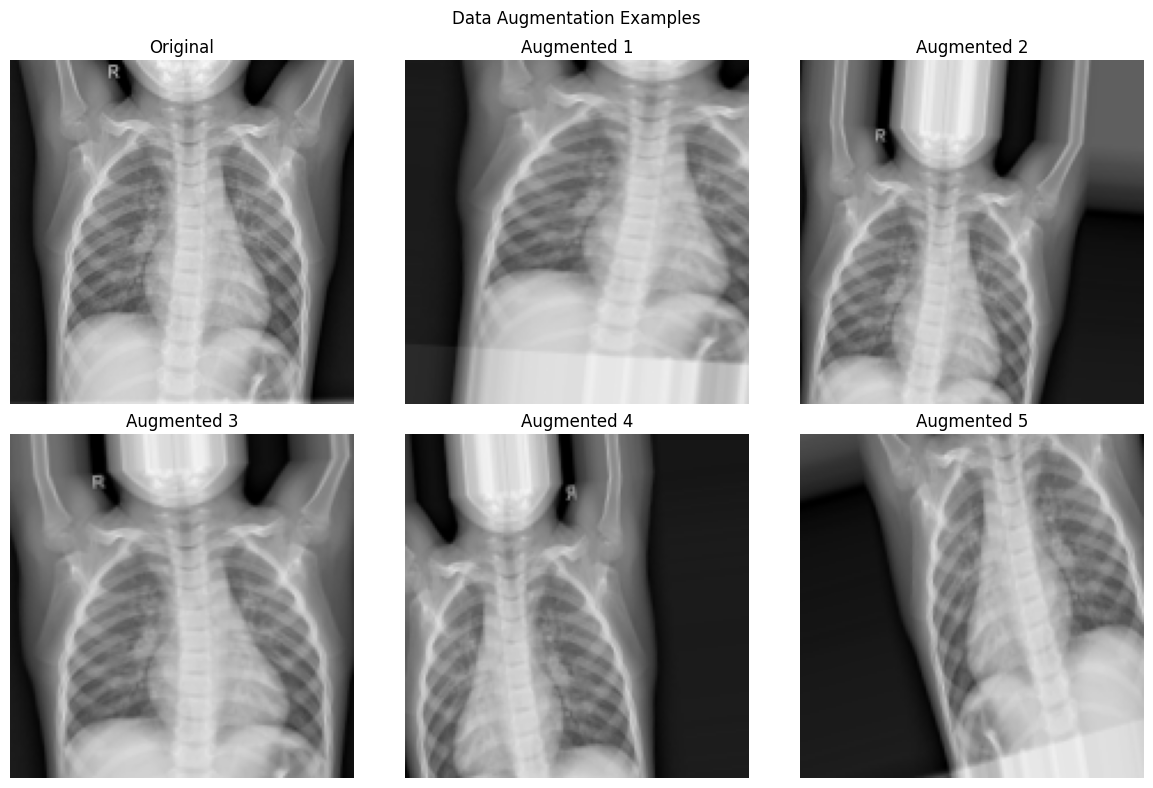

In [ ]:
# Feature Engineering (Data Augmentation)


def visualize_augmentation(original_img_path, num_augmented=5):
    # Load original image
    original_img = Image.open(original_img_path)
    original_img = original_img.resize((IMG_HEIGHT, IMG_WIDTH))
    
    # Convert to array and ensure it has 3 channels
    img_array = np.array(original_img)
    if len(img_array.shape) == 2:  # Grayscale
        img_array = np.stack([img_array] * 3, axis=-1)  
    elif img_array.shape[2] == 1:  # Single channel
        img_array = np.concatenate([img_array] * 3, axis=-1)  
    
    img_array = img_array.astype('float32') / 255.0
    img_array = np.expand_dims(img_array, axis=0)  
    
    # Apply data augmentation
    aug_generator = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        fill_mode='nearest'
    )
    
    aug_iter = aug_generator.flow(img_array, batch_size=1)
    
    # Plot original and augmented images
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    # Convert original back to display format
    original_display = (img_array[0] * 255).astype('uint8')
    axes[0, 0].imshow(original_display)
    axes[0, 0].set_title('Original')
    axes[0, 0].axis('off')
    
    for i in range(1, 6):
        aug_img = next(aug_iter)[0]  
        aug_img_display = (aug_img * 255).astype('uint8')  
        row = i // 3
        col = i % 3
        axes[row, col].imshow(aug_img_display)
        axes[row, col].set_title(f'Augmented {i}')
        axes[row, col].axis('off')
    
    plt.suptitle('Data Augmentation Examples')
    plt.tight_layout()
    plt.show()


sample_normal_img = os.path.join(train_dir, 'NORMAL', os.listdir(os.path.join(train_dir, 'NORMAL'))[0])
visualize_augmentation(sample_normal_img)

In [ ]:

# Build a custom CNN model for pneumonia detection
def create_base_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)):
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        
        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        
        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        
        # Fourth Convolutional Block
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        
        # Flatten and Dense layers
        Flatten(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')  
    ])
    
    return model

# Create the base model
base_model = create_base_model()
print("Base model architecture:")
base_model.summary()



Base model architecture:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  

In [13]:
def create_optimized_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)):
    model = Sequential([
        # First Block
        Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(2, 2),
        
        # Second Block
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(2, 2),
        
        # Third Block
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(2, 2),
        
        # Fourth Block
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(2, 2),
        
        # Flatten and Dense
        Flatten(),
        Dropout(0.5),
        Dense(512),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
        
    return model

# Create the optimized model
optimized_model = create_optimized_model()
print("Optimized model architecture:")
optimized_model.summary()


Optimized model architecture:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 150, 150, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 150, 150, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 batch_normalization_1 (

In [ ]:

# Compile the base model
base_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)


print(f"Optimizer: Adam with learning rate 0.001")
print(f"Loss function: Binary Crossentropy")
print(f"Metrics: Accuracy, Precision, Recall")

# Compile the optimized model
optimized_model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss='binary_crossentropy', 
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)


print(f"Optimizer: Adam with learning rate 0.0001")
print(f"Loss function: Binary Crossentropy")
print(f"Metrics: Accuracy, Precision, Recall")

Optimizer: Adam with learning rate 0.001
Loss function: Binary Crossentropy
Metrics: Accuracy, Precision, Recall
Optimizer: Adam with learning rate 0.0001
Loss function: Binary Crossentropy
Metrics: Accuracy, Precision, Recall


In [ ]:


# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Calculate steps per epoch
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = max(1, validation_generator.samples // validation_generator.batch_size)


print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")
print(f"Training batch size: {train_generator.batch_size}")
print(f"Validation batch size: {validation_generator.batch_size}")

# Train the base model
print("\nStarting training for base model...")
base_history = base_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("Base model training completed!")

# Print final stats

print(f"Final Training Loss: {base_history.history['loss'][-1]}")
print(f"Final Validation Loss: {base_history.history['val_loss'][-1]}")
print(f"Final Training Accuracy: {base_history.history.get('accuracy', [None])[-1]}")
print(f"Final Validation Accuracy: {base_history.history.get('val_accuracy', [None])[-1]}")


Steps per epoch: 163
Validation steps: 2
Training batch size: 32
Validation batch size: 8

Starting training for base model...
Epoch 1/50


163/163 [==============================] - 60s 362ms/step - loss: 0.4816 - accuracy: 0.7855 - precision: 0.7989 - recall: 0.9505 - val_loss: 0.7370 - val_accuracy: 0.6875 - val_precision: 0.6154 - val_recall: 1.0000 - lr: 0.0010
Epoch 2/50
163/163 [==============================] - 58s 354ms/step - loss: 0.2967 - accuracy: 0.8769 - precision: 0.9085 - recall: 0.9277 - val_loss: 0.8816 - val_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000 - lr: 0.0010
Epoch 3/50
163/163 [==============================] - 58s 357ms/step - loss: 0.2134 - accuracy: 0.9074 - precision: 0.9351 - recall: 0.9406 - val_loss: 0.9059 - val_accuracy: 0.6875 - val_precision: 0.6154 - val_recall: 1.0000 - lr: 0.0010
Epoch 4/50
163/163 [==============================] - 58s 358ms/step - loss: 0.1824 - accuracy: 0.9331 - precision: 0.9565 - recall: 0.9533 - val_loss:

In [ ]:


# Calculate steps per epoch 
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = max(1, validation_generator.samples // validation_generator.batch_size)


print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")
print(f"Training batch size: {train_generator.batch_size}")
print(f"Validation batch size: {validation_generator.batch_size}")

# Train the optimized model
print("\nStarting training for optimized model...")
optimized_history = optimized_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("Optimized model training completed!")

# Print final stats

print(f"Final Training Loss: {optimized_history.history['loss'][-1]}")
print(f"Final Validation Loss: {optimized_history.history['val_loss'][-1]}")
print(f"Final Training Accuracy: {optimized_history.history.get('accuracy', [None])[-1]}")
print(f"Final Validation Accuracy: {optimized_history.history.get('val_accuracy', [None])[-1]}")


Steps per epoch: 163
Validation steps: 2
Training batch size: 32
Validation batch size: 8

Starting training for optimized model...
Epoch 1/50
163/163 [==============================] - 72s 433ms/step - loss: 0.3963 - accuracy: 0.8461 - precision: 0.9663 - recall: 0.8214 - val_loss: 1.4953 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - lr: 1.0000e-04
Epoch 2/50
163/163 [==============================] - 70s 431ms/step - loss: 0.1987 - accuracy: 0.9302 - precision: 0.9602 - recall: 0.9453 - val_loss: 2.2392 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - lr: 1.0000e-04
Epoch 3/50
163/163 [==============================] - 70s 431ms/step - loss: 0.1676 - accuracy: 0.9350 - precision: 0.9597 - recall: 0.9525 - val_loss: 2.0024 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - lr: 1.0000e-04
Epoch 4/50
163/163 [==============================] - 71s 434ms/step - loss: 0.1565 - accuracy: 0.9394 - precision: 0.9604 - recall: 0.9

In [ ]:
# \Compare Training Performance of Both Models 
print("=== BASE MODEL FINAL TRAINING METRICS ===")
base_final_accuracy = base_history.history['accuracy'][-1]
base_final_val_accuracy = base_history.history['val_accuracy'][-1]
base_final_loss = base_history.history['loss'][-1]
base_final_val_loss = base_history.history['val_loss'][-1]
base_final_precision = base_history.history['precision'][-1]
base_final_val_precision = base_history.history['val_precision'][-1]
base_final_recall = base_history.history['recall'][-1]
base_final_val_recall = base_history.history['val_recall'][-1]

print(f"\nTraining Set Performance:")
print(f"Loss: {base_final_loss:.4f}")
print(f"Accuracy: {base_final_accuracy:.4f}")
print(f"Precision: {base_final_precision:.4f}")
print(f"Recall: {base_final_recall:.4f}")

print(f"\nValidation Set Performance:")
print(f"Loss: {base_final_val_loss:.4f}")
print(f"Accuracy: {base_final_val_accuracy:.4f}")
print(f"Precision: {base_final_val_precision:.4f}")
print(f"Recall: {base_final_val_recall:.4f}")

print("\n" + "="*50)

print("=== OPTIMIZED MODEL FINAL TRAINING METRICS ===")

print("Available metrics in optimized model history:", list(optimized_history.history.keys()))

optimized_final_accuracy = optimized_history.history['accuracy'][-1]
optimized_final_val_accuracy = optimized_history.history['val_accuracy'][-1]
optimized_final_loss = optimized_history.history['loss'][-1]
optimized_final_val_loss = optimized_history.history['val_loss'][-1]


optimized_final_precision = optimized_history.history.get('precision', optimized_history.history.get('precision_1', [0]))[-1]
optimized_final_val_precision = optimized_history.history.get('val_precision', optimized_history.history.get('val_precision_1', [0]))[-1]
optimized_final_recall = optimized_history.history.get('recall', optimized_history.history.get('recall_1', [0]))[-1]
optimized_final_val_recall = optimized_history.history.get('val_recall', optimized_history.history.get('val_recall_1', [0]))[-1]

print(f"\nTraining Set Performance:")
print(f"Loss: {optimized_final_loss:.4f}")
print(f"Accuracy: {optimized_final_accuracy:.4f}")
print(f"Precision: {optimized_final_precision:.4f}")
print(f"Recall: {optimized_final_recall:.4f}")

print(f"\nValidation Set Performance:")
print(f"Loss: {optimized_final_val_loss:.4f}")
print(f"Accuracy: {optimized_final_val_accuracy:.4f}")
print(f"Precision: {optimized_final_val_precision:.4f}")
print(f"Recall: {optimized_final_val_recall:.4f}")

print("\n" + "="*50)

print("=== COMPARISON ===")
print("Training Set:")
print(f"Loss Difference: {optimized_final_loss - base_final_loss:.4f}")
print(f"Accuracy Difference: {optimized_final_accuracy - base_final_accuracy:.4f}")
print(f"Precision Difference: {optimized_final_precision - base_final_precision:.4f}")
print(f"Recall Difference: {optimized_final_recall - base_final_recall:.4f}")

print("\nValidation Set:")
print(f"Loss Difference: {optimized_final_val_loss - base_final_val_loss:.4f}")
print(f"Accuracy Difference: {optimized_final_val_accuracy - base_final_val_accuracy:.4f}")
print(f"Precision Difference: {optimized_final_val_precision - base_final_val_precision:.4f}")
print(f"Recall Difference: {optimized_final_val_recall - base_final_val_recall:.4f}")

=== BASE MODEL FINAL TRAINING METRICS ===

Training Set Performance:
Loss: 0.0980
Accuracy: 0.9638
Precision: 0.9785
Recall: 0.9726

Validation Set Performance:
Loss: 0.3649
Accuracy: 0.8750
Precision: 0.8000
Recall: 1.0000

=== OPTIMIZED MODEL FINAL TRAINING METRICS ===
Available metrics in optimized model history: ['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'lr']

Training Set Performance:
Loss: 0.0949
Accuracy: 0.9628
Precision: 0.9750
Recall: 0.9750

Validation Set Performance:
Loss: 0.4350
Accuracy: 0.8125
Precision: 0.7778
Recall: 0.8750

=== COMPARISON ===
Training Set:
Loss Difference: -0.0031
Accuracy Difference: -0.0010
Precision Difference: -0.0035
Recall Difference: 0.0023

Validation Set:
Loss Difference: 0.0700
Accuracy Difference: -0.0625
Precision Difference: -0.0222
Recall Difference: -0.1250


=== BASE MODEL TRAINING HISTORY ===


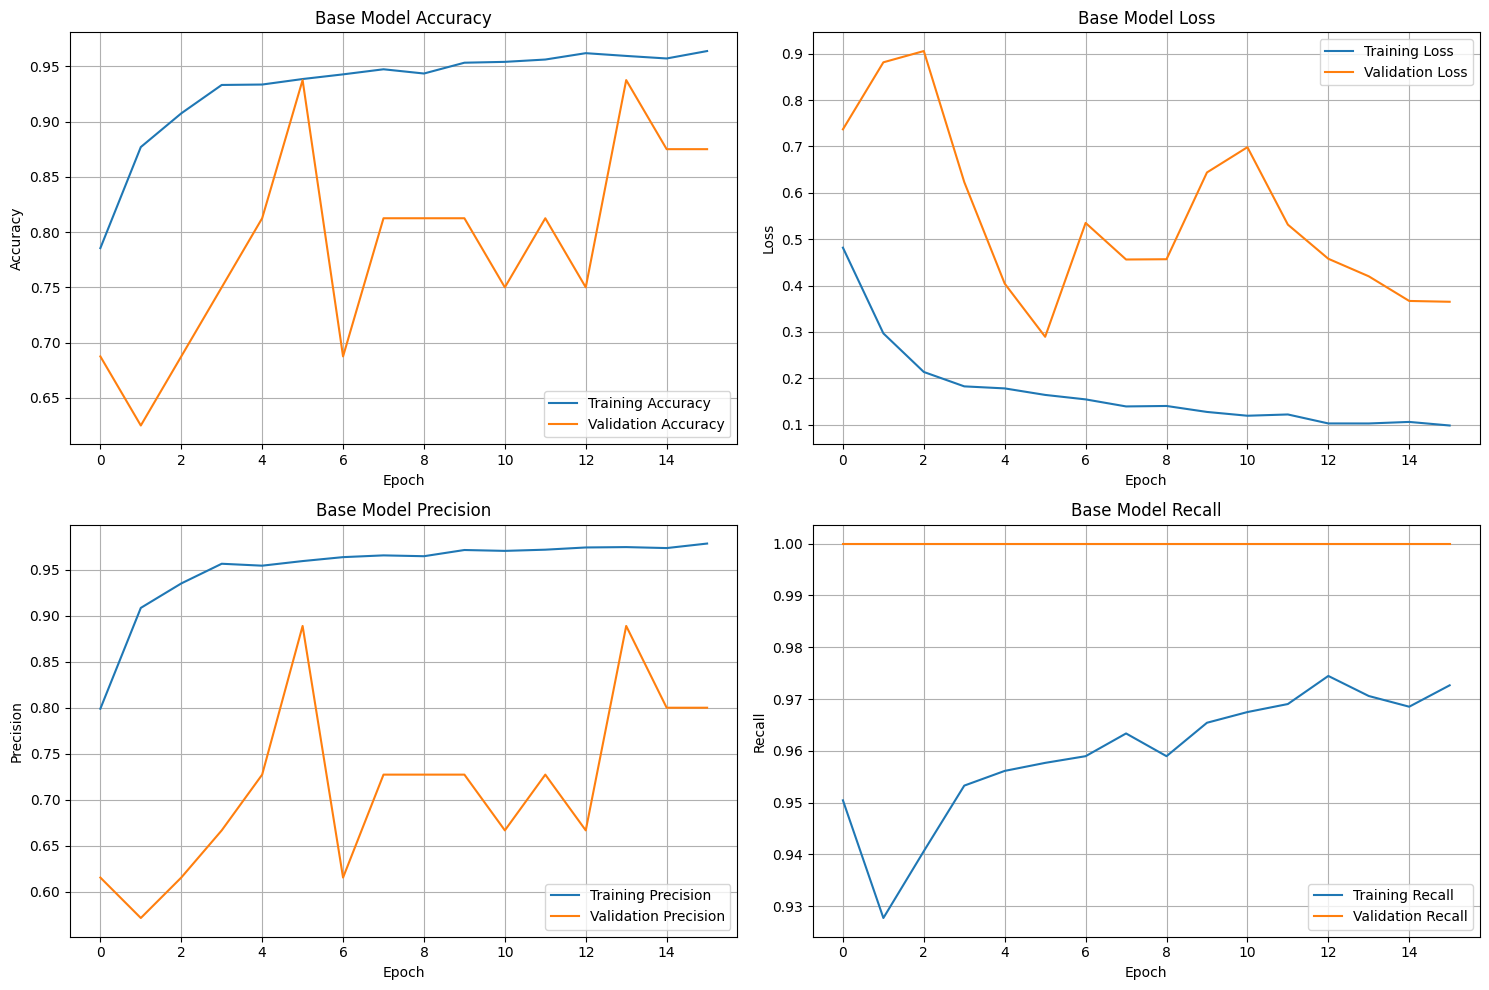

=== OPTIMIZED MODEL TRAINING HISTORY ===


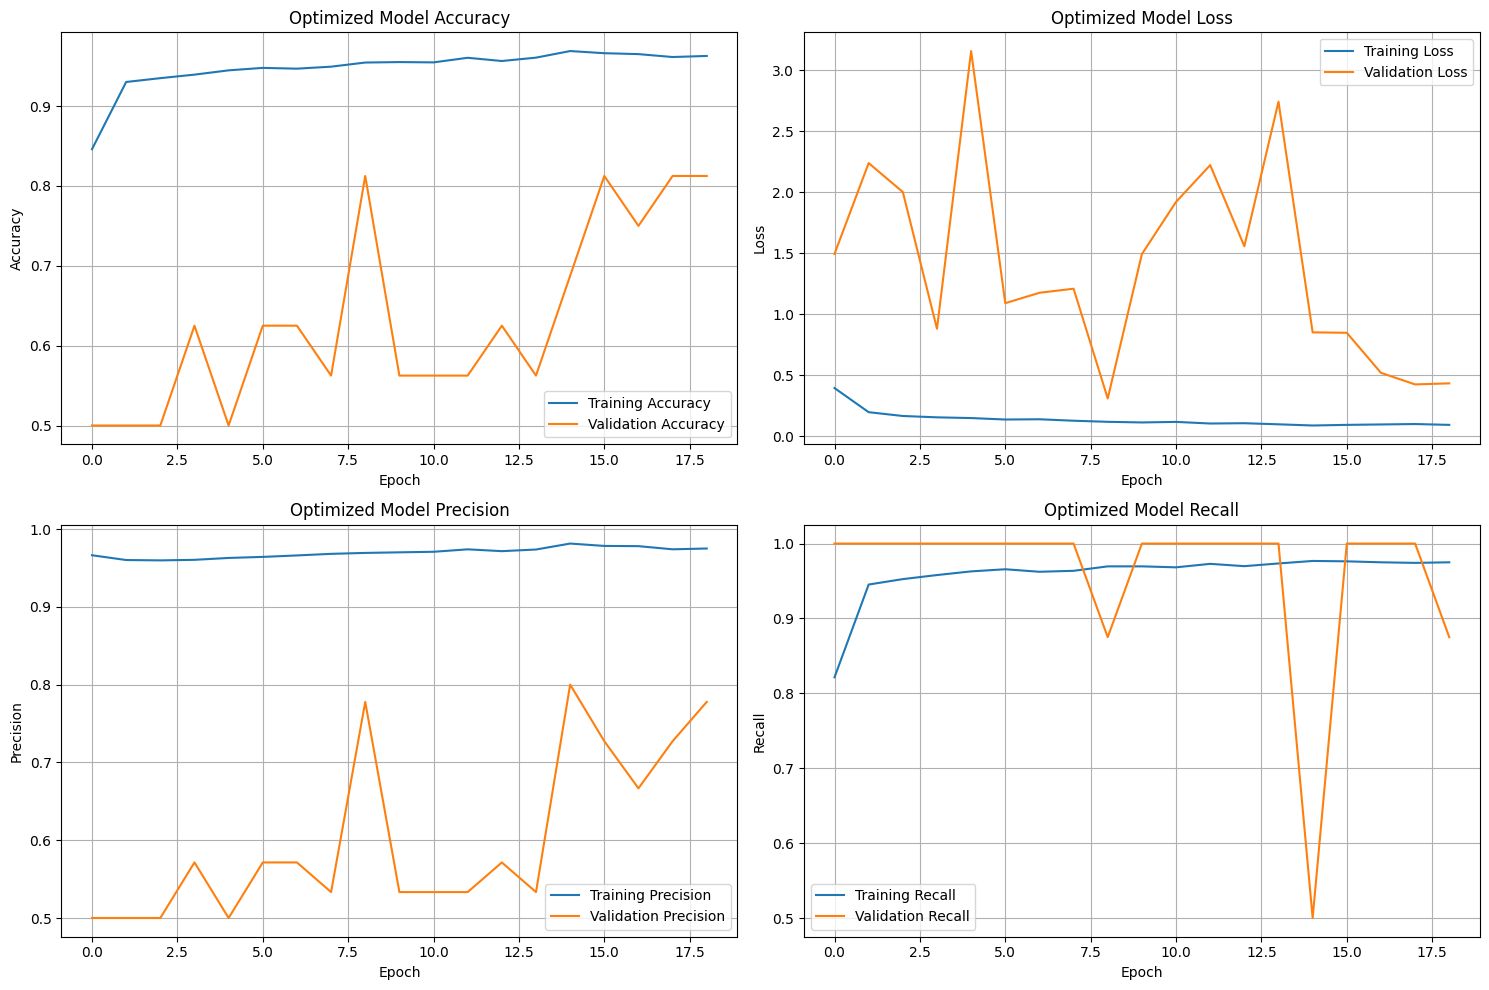


=== COMPARISON OF FINAL METRICS ===
Base Model - Training Accuracy: 0.9638, Validation Accuracy: 0.8750
Optimized Model - Training Accuracy: 0.9628, Validation Accuracy: 0.8125
Base Model - Training Loss: 0.0980, Validation Loss: 0.3649
Optimized Model - Training Loss: 0.0949, Validation Loss: 0.4350


In [ ]:

# Plot training history for both models
def plot_training_history(history, title_prefix="Model"):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot training & validation accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 0].set_title(f'{title_prefix} Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Plot training & validation loss
    axes[0, 1].plot(history.history['loss'], label='Training Loss')
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 1].set_title(f'{title_prefix} Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Plot training & validation precision
    
    precision_key = 'precision' if 'precision' in history.history else 'precision_1' if 'precision_1' in history.history else None
    val_precision_key = 'val_precision' if 'val_precision' in history.history else 'val_precision_1' if 'val_precision_1' in history.history else None
    
    if precision_key and val_precision_key:
        axes[1, 0].plot(history.history[precision_key], label='Training Precision')
        axes[1, 0].plot(history.history[val_precision_key], label='Validation Precision')
        axes[1, 0].set_title(f'{title_prefix} Precision')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].legend()
        axes[1, 0].grid(True)
    else:
        axes[1, 0].text(0.5, 0.5, 'Precision metrics not available', 
                        horizontalalignment='center', verticalalignment='center', 
                        transform=axes[1, 0].transAxes)
        axes[1, 0].set_title(f'{title_prefix} Precision')
    
    # Plot training & validation recall
    
    recall_key = 'recall' if 'recall' in history.history else 'recall_1' if 'recall_1' in history.history else None
    val_recall_key = 'val_recall' if 'val_recall' in history.history else 'val_recall_1' if 'val_recall_1' in history.history else None
    
    if recall_key and val_recall_key:
        axes[1, 1].plot(history.history[recall_key], label='Training Recall')
        axes[1, 1].plot(history.history[val_recall_key], label='Validation Recall')
        axes[1, 1].set_title(f'{title_prefix} Recall')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].legend()
        axes[1, 1].grid(True)
    else:
        axes[1, 1].text(0.5, 0.5, 'Recall metrics not available', 
                        horizontalalignment='center', verticalalignment='center', 
                        transform=axes[1, 1].transAxes)
        axes[1, 1].set_title(f'{title_prefix} Recall')
    
    plt.tight_layout()
    plt.show()

# Plot base model history
print("=== BASE MODEL TRAINING HISTORY ===")
plot_training_history(base_history, "Base Model")

# Plot optimized model history
print("=== OPTIMIZED MODEL TRAINING HISTORY ===")
plot_training_history(optimized_history, "Optimized Model")

# Print final metrics for both models
print(f"\n=== COMPARISON OF FINAL METRICS ===")
print(f"Base Model - Training Accuracy: {base_final_accuracy:.4f}, Validation Accuracy: {base_final_val_accuracy:.4f}")
print(f"Optimized Model - Training Accuracy: {optimized_final_accuracy:.4f}, Validation Accuracy: {optimized_final_val_accuracy:.4f}")
print(f"Base Model - Training Loss: {base_final_loss:.4f}, Validation Loss: {base_final_val_loss:.4f}")
print(f"Optimized Model - Training Loss: {optimized_final_loss:.4f}, Validation Loss: {optimized_final_val_loss:.4f}")

=== BASE MODEL TEST SET PERFORMANCE ===
20/20 [==============================] - 4s 169ms/step - loss: 0.4042 - accuracy: 0.8333 - precision: 0.7992 - recall: 0.9795

Test Set Performance:
Loss: 0.4042
Accuracy: 0.8333
Precision: 0.7992
Recall: 0.9795

=== OPTIMIZED MODEL TEST SET PERFORMANCE ===
20/20 [==============================] - 4s 204ms/step - loss: 0.2524 - accuracy: 0.9103 - precision: 0.9113 - recall: 0.9487

Test Set Performance:
Loss: 0.2524
Accuracy: 0.9103
Precision: 0.9113
Recall: 0.9487
20/20 [==============================] - 4s 204ms/step

=== DETAILED METRICS COMPARISON ===
Base Model:
  Accuracy: 0.8333
  Precision: 0.7992
  Recall: 0.9795
  F1-Score: 0.8802
  ROC AUC: 0.9431

Optimized Model:
  Accuracy: 0.9103
  Precision: 0.9113
  Recall: 0.9487
  F1-Score: 0.9296
  ROC AUC: 0.9566

=== IMPROVEMENTS ===
Accuracy Improvement: 0.0769
Precision Improvement: 0.1122
Recall Improvement: -0.0308
F1-Score Improvement: 0.0495
ROC AUC Improvement: 0.0135


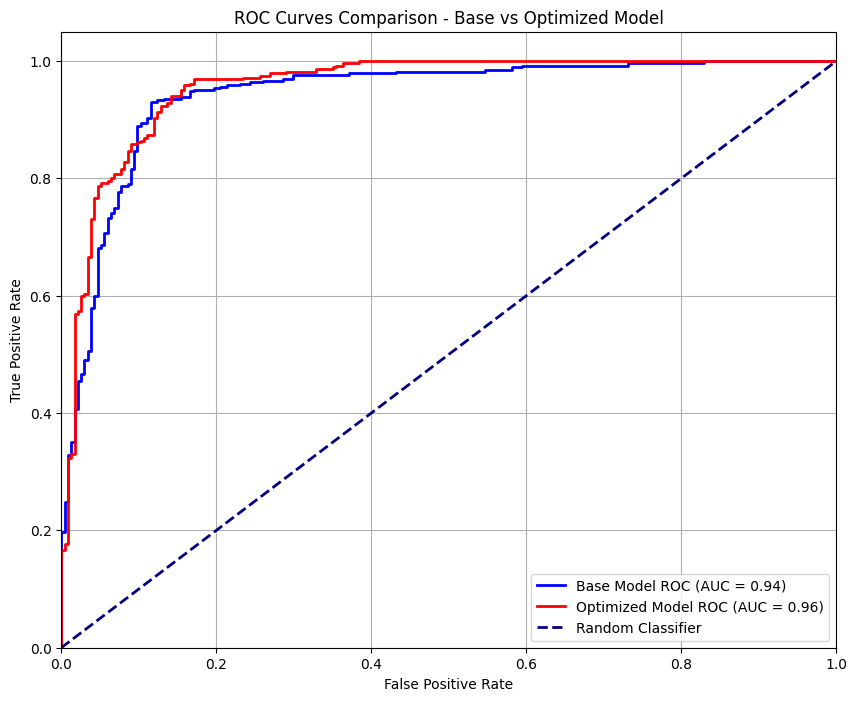

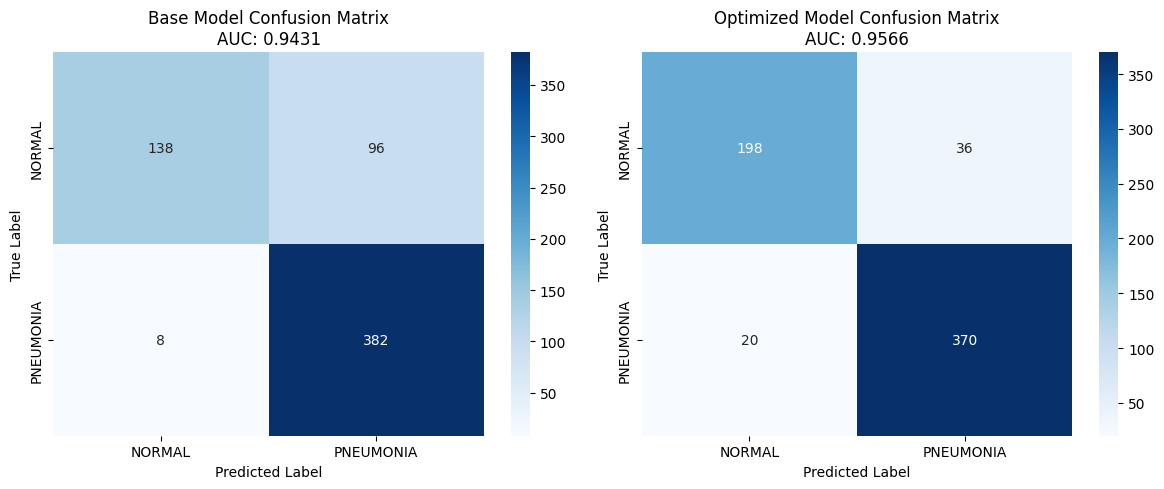

In [ ]:

# Evaluate base model on test set
print("=== BASE MODEL TEST SET PERFORMANCE ===")
test_generator.reset()
base_test_loss, base_test_accuracy, base_test_precision, base_test_recall = base_model.evaluate(
    test_generator,
    steps=test_generator.samples // test_generator.batch_size + 1,
    verbose=1
)

print(f"\nTest Set Performance:")
print(f"Loss: {base_test_loss:.4f}")
print(f"Accuracy: {base_test_accuracy:.4f}")
print(f"Precision: {base_test_precision:.4f}")
print(f"Recall: {base_test_recall:.4f}")

# Evaluate optimized model on test set
print("\n=== OPTIMIZED MODEL TEST SET PERFORMANCE ===")
test_generator.reset()
optimized_test_loss, optimized_test_accuracy, optimized_test_precision, optimized_test_recall = optimized_model.evaluate(
    test_generator,
    steps=test_generator.samples // test_generator.batch_size + 1,
    verbose=1
)

print(f"\nTest Set Performance:")
print(f"Loss: {optimized_test_loss:.4f}")
print(f"Accuracy: {optimized_test_accuracy:.4f}")
print(f"Precision: {optimized_test_precision:.4f}")
print(f"Recall: {optimized_test_recall:.4f}")

# Generate predictions for confusion matrix and ROC curve
test_generator.reset()
base_predictions = base_model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
base_predictions = base_predictions.flatten()[:test_generator.samples]
base_true_classes = test_generator.classes[:test_generator.samples]
base_predicted_classes = (base_predictions > 0.5).astype(int)

test_generator.reset()  # Reset for optimized model
optimized_predictions = optimized_model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
optimized_predictions = optimized_predictions.flatten()[:test_generator.samples]
optimized_predicted_classes = (optimized_predictions > 0.5).astype(int)


# Calculate ROC curves
base_fpr, base_tpr, _ = roc_curve(base_true_classes, base_predictions)
base_roc_auc = auc(base_fpr, base_tpr)

optimized_fpr, optimized_tpr, _ = roc_curve(base_true_classes, optimized_predictions)
optimized_roc_auc = auc(optimized_fpr, optimized_tpr)




base_accuracy = accuracy_score(base_true_classes, base_predicted_classes)
base_precision = precision_score(base_true_classes, base_predicted_classes)
base_recall = recall_score(base_true_classes, base_predicted_classes)
base_f1 = f1_score(base_true_classes, base_predicted_classes)

optimized_accuracy = accuracy_score(base_true_classes, optimized_predicted_classes)
optimized_precision = precision_score(base_true_classes, optimized_predicted_classes)
optimized_recall = recall_score(base_true_classes, optimized_predicted_classes)
optimized_f1 = f1_score(base_true_classes, optimized_predicted_classes)

print(f"\n=== DETAILED METRICS COMPARISON ===")
print("Base Model:")
print(f"  Accuracy: {base_accuracy:.4f}")
print(f"  Precision: {base_precision:.4f}")
print(f"  Recall: {base_recall:.4f}")
print(f"  F1-Score: {base_f1:.4f}")
print(f"  ROC AUC: {base_roc_auc:.4f}")

print("\nOptimized Model:")
print(f"  Accuracy: {optimized_accuracy:.4f}")
print(f"  Precision: {optimized_precision:.4f}")
print(f"  Recall: {optimized_recall:.4f}")
print(f"  F1-Score: {optimized_f1:.4f}")
print(f"  ROC AUC: {optimized_roc_auc:.4f}")

print(f"\n=== IMPROVEMENTS ===")
print(f"Accuracy Improvement: {optimized_accuracy - base_accuracy:.4f}")
print(f"Precision Improvement: {optimized_precision - base_precision:.4f}")
print(f"Recall Improvement: {optimized_recall - base_recall:.4f}")
print(f"F1-Score Improvement: {optimized_f1 - base_f1:.4f}")
print(f"ROC AUC Improvement: {optimized_roc_auc - base_roc_auc:.4f}")

# Plot ROC curves for both models
plt.figure(figsize=(10, 8))
plt.plot(base_fpr, base_tpr, color='blue', lw=2, label=f'Base Model ROC (AUC = {base_roc_auc:.2f})')
plt.plot(optimized_fpr, optimized_tpr, color='red', lw=2, label=f'Optimized Model ROC (AUC = {optimized_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison - Base vs Optimized Model')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Generate confusion matrices for both models
# Confusion matrix for base model
cm_base = confusion_matrix(base_true_classes, base_predicted_classes)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title(f'Base Model Confusion Matrix\nAUC: {base_roc_auc:.4f}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Confusion matrix for optimized model
cm_optimized = confusion_matrix(base_true_classes, optimized_predicted_classes)
plt.subplot(1, 2, 2)
sns.heatmap(cm_optimized, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title(f'Optimized Model Confusion Matrix\nAUC: {optimized_roc_auc:.4f}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()

In [ ]:

# Save the base model
base_model.save('pneumonia_cnn_base_model_best.h5')
print("Base model saved as 'pneumonia_cnn_base_model_best.h5'")

# Save the optimized model
optimized_model.save('pneumonia_cnn_optimized_model_best.h5')
print("Optimized model saved as 'pneumonia_cnn_optimized_model_best.h5'")

# Save both training histories
import pickle
with open('base_training_history_best.pkl', 'wb') as f:
    pickle.dump(base_history.history, f)
print("Base training history saved as 'base_training_history_best.pkl'")

with open('optimized_training_history_best.pkl', 'wb') as f:
    pickle.dump(optimized_history.history, f)
print("Optimized training history saved as 'optimized_training_history_best.pkl'")

print("\nBoth models and their training histories have been saved!")

Base model saved as 'pneumonia_cnn_base_model_best.h5'
Optimized model saved as 'pneumonia_cnn_optimized_model_best.h5'
Base training history saved as 'base_training_history_best.pkl'
Optimized training history saved as 'optimized_training_history_best.pkl'

Both models and their training histories have been saved!


In [ ]:

# Load the saved models and make predictions on sample images
def load_and_predict_both_models(image_path):
    # Load both models
    base_model = keras.models.load_model('pneumonia_cnn_base_model.h5', 
                                        custom_objects={'Precision': Precision, 'Recall': Recall})
    optimized_model = keras.models.load_model('pneumonia_cnn_optimized_model.h5', 
                                             custom_objects={'Precision': Precision, 'Recall': Recall})
    
    # Load and preprocess the image
    img = Image.open(image_path)
    img = img.resize((IMG_HEIGHT, IMG_WIDTH))
    img_array = np.array(img)
    if len(img_array.shape) == 2:  # Grayscale to RGB
        img_array = np.stack([img_array] * 3, axis=-1)
    img_array = img_array.astype('float32') / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Make predictions with both models
    base_prediction = base_model.predict(img_array)[0][0]
    optimized_prediction = optimized_model.predict(img_array)[0][0]
    
    base_class = 'PNEUMONIA' if base_prediction > 0.5 else 'NORMAL'
    optimized_class = 'PNEUMONIA' if optimized_prediction > 0.5 else 'NORMAL'
    
    return (base_class, base_prediction), (optimized_class, optimized_prediction)

# Test on a few sample images from test set
test_normal_samples = os.listdir(os.path.join(test_dir, 'NORMAL'))[:3]
test_pneumonia_samples = os.listdir(os.path.join(test_dir, 'PNEUMONIA'))[:3]

print("Predictions on NORMAL samples:")
for sample in test_normal_samples:
    img_path = os.path.join(test_dir, 'NORMAL', sample)
    base_pred, opt_pred = load_and_predict_both_models(img_path)
    print(f"Image: {sample}")
    print(f"  Base Model: {base_pred[0]} (Confidence: {base_pred[1]:.4f})")
    print(f"  Optimized Model: {opt_pred[0]} (Confidence: {opt_pred[1]:.4f})")
    print(f"  Actual: NORMAL")
    print()

print("\nPredictions on PNEUMONIA samples:")
for sample in test_pneumonia_samples:
    img_path = os.path.join(test_dir, 'PNEUMONIA', sample)
    base_pred, opt_pred = load_and_predict_both_models(img_path)
    print(f"Image: {sample}")
    print(f"  Base Model: {base_pred[0]} (Confidence: {base_pred[1]:.4f})")
    print(f"  Optimized Model: {opt_pred[0]} (Confidence: {opt_pred[1]:.4f})")
    print(f"  Actual: PNEUMONIA")
    print()

Predictions on NORMAL samples:
1/1 [==============================] - 0s 95ms/step
Image: IM-0001-0001.jpeg
  Base Model: NORMAL (Confidence: 0.1165)
  Optimized Model: NORMAL (Confidence: 0.0077)
  Actual: NORMAL

1/1 [==============================] - 0s 95ms/step
Image: IM-0003-0001.jpeg
  Base Model: NORMAL (Confidence: 0.2056)
  Optimized Model: NORMAL (Confidence: 0.0009)
  Actual: NORMAL

1/1 [==============================] - 0s 96ms/step
Image: IM-0005-0001.jpeg
  Base Model: NORMAL (Confidence: 0.1441)
  Optimized Model: NORMAL (Confidence: 0.0091)
  Actual: NORMAL


Predictions on PNEUMONIA samples:
1/1 [==============================] - 0s 97ms/step
Image: person100_bacteria_475.jpeg
  Base Model: NORMAL (Confidence: 0.2230)
  Optimized Model: PNEUMONIA (Confidence: 0.9727)
  Actual: PNEUMONIA

1/1 [==============================] - 0s 96ms/step
Image: person100_bacteria_477.jpeg
  Base Model: PNEUMONIA (Confidence: 0.7380)
  Optimized Model: PNEUMONIA (Confidence: 0.9514)


In [24]:
# Cell 20: Document & Interpret Results for Both Models
print("=== BASE MODEL PERFORMANCE SUMMARY ===")
print(f"Test Accuracy: {base_accuracy:.4f}")
print(f"Test Precision: {base_precision:.4f}")
print(f"Test Recall: {base_recall:.4f}")
print(f"Test F1-Score: {base_f1:.4f}")
print(f"ROC AUC Score: {base_roc_auc:.2f}")

print(f"\n=== OPTIMIZED MODEL PERFORMANCE SUMMARY ===")
print(f"Test Accuracy: {optimized_accuracy:.4f}")
print(f"Test Precision: {optimized_precision:.4f}")
print(f"Test Recall: {optimized_recall:.4f}")
print(f"Test F1-Score: {optimized_f1:.4f}")
print(f"ROC AUC Score: {optimized_roc_auc:.2f}")

print(f"\n=== COMPARISON ===")
print(f"Accuracy Improvement: {optimized_accuracy - base_accuracy:.4f}")
print(f"Precision Improvement: {optimized_precision - base_precision:.4f}")
print(f"Recall Improvement: {optimized_recall - base_recall:.4f}")
print(f"F1-Score Improvement: {optimized_f1 - base_f1:.4f}")
print(f"ROC AUC Improvement: {optimized_roc_auc - base_roc_auc:.4f}")







=== BASE MODEL PERFORMANCE SUMMARY ===
Test Accuracy: 0.8333
Test Precision: 0.7992
Test Recall: 0.9795
Test F1-Score: 0.8802
ROC AUC Score: 0.94

=== OPTIMIZED MODEL PERFORMANCE SUMMARY ===
Test Accuracy: 0.9103
Test Precision: 0.9113
Test Recall: 0.9487
Test F1-Score: 0.9296
ROC AUC Score: 0.96

=== COMPARISON ===
Accuracy Improvement: 0.0769
Precision Improvement: 0.1122
Recall Improvement: -0.0308
F1-Score Improvement: 0.0495
ROC AUC Improvement: 0.0135
